In [10]:
# install machine gnostics
# recommended to run in a new virtual environment

# !pip install machinegnostics #<-- Uncomment this line to install the package

# Small data (with noise) and regression

### **Overview**
The **Machine Gnostics LinearRegressor** is a robust modeling tool that abandons the Gaussian assumptions of classical Ordinary Least Squares (OLS). Instead of minimizing squared Euclidean errors, this model operates within a *Machine Gnostics [Riemannian geometric] framework**, treating data as events within a curved space of uncertainty.

By leveraging the **Ideal Gnostic Cycle (IGC)**, this regressor optimizes thermodynamic criteria—specifically maximizing **Information** and minimizing **Entropy**—rather than simple variance. This approach ensures that the model is naturally robust to outliers (outer robustness) or inliers (inner robustness), depending on the chosen criterion, without requiring manual trimming or subjective thresholding.

---

### **Theoretical Background (Note for Users)**

For those familiar with the *Mathematical Gnostics* framework, this regressor implements the **Gnostic Weighted Least Squares (GWLS)** methodology. Key theoretical distinctions include:

*   **Thermodynamic Optimization:**
    Unlike statistical regression which minimizes variance (a mechanical concept), this model minimizes the **Residual Entropy** ($f_J - f_I$) or maximizes **Fidelity** ($f_E$) of the system. It seeks the path of maximum information yield rather than just the line of best fit.

*   **Riemannian Metric:**
    The model rejects the flat Euclidean space of standard statistics. It applies a **Riemannian metric** determined by the data itself. The local curvature of the space defines how errors are measured, automatically down-weighting data points that generate high uncertainty (entropy).

*   **Dynamic Weighting (Fidelity & Irrelevance):**
    Weights are not fixed. In every iteration of the solver, the model calculates the **Gnostic Fidelity** ($f$) and **Irrelevance** ($h$) of each data event.
    *   *Outlier Robustness:* High irrelevance ($h \to \pm 1$) results in low fidelity ($f \to 0$), effectively filtering out contaminated data dynamically.

*   **Regression in Probabilities:**
    To ensure scale invariance and handle diverse physical units, the model can operate on **Gnostic Probabilities** rather than raw values. This transforms all inputs to the dimensionless domain $(0,1)$ using the **Estimating Global Distribution Function (EGDF)**, allowing for a consistent evaluation of variable impact.

***


## Example 1: Simple Linear Regression

A basic example showing how to use the Linear Regressor with noisy data and outliers.

In [11]:
import numpy as np
from machinegnostics.models import LinearRegressor

# Generate linear data with noise and outliers
np.random.seed(42)
X = np.linspace(0, 2, 10).reshape(-1, 1)
y = 10 * X.ravel() + 1  # True: y = 10x + 1

# Add noise
y += np.random.normal(0, 2, 10)

# Add an outlier
y[2] += 28.0

# Fit the model
model = LinearRegressor()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

print("Model fitted successfully!")
print(f"Coefficients (Intercept, Slope): {model.coefficients}")
print(f"True relationship: y = 10x + 1")
print(f"MSE: {np.mean((y_pred - y)**2):.4f}")

Model fitted successfully!
Coefficients (Intercept, Slope): [ 1.71210677 10.21695427]
True relationship: y = 10x + 1
MSE: 83.0394


### Basic Visualization

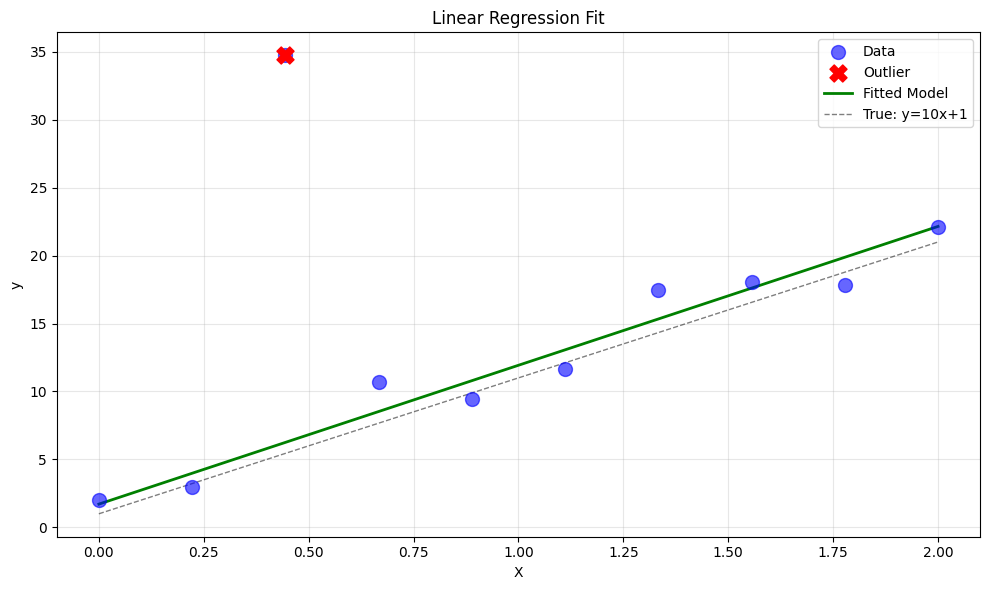

In [12]:
import matplotlib.pyplot as plt

# Generate smooth line for visualization
X_test = np.linspace(0, 2, 100).reshape(-1, 1)
y_test = model.predict(X_test)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', s=100, label='Data', zorder=3, alpha=0.6)
plt.scatter(X[2], y[2], color='red', s=150, label='Outlier', zorder=4, marker='X')
plt.plot(X_test, y_test, 'g-', linewidth=2, label='Fitted Model')

# True relationship for reference
y_true = 10 * X_test + 1
plt.plot(X_test, y_true, 'k--', linewidth=1, alpha=0.5, label='True: y=10x+1')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression Fit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Example 2: Understanding Gnostic Weights

This example shows how the model automatically identifies and down-weights outliers.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from machinegnostics.models import LinearRegressor

# Generate data with outlier
np.random.seed(42)
X = np.linspace(0, 2, 10).reshape(-1, 1)
y = 10 * X.ravel() + 1 + np.random.normal(0, 2, 10)
y[2] += 28.0  # Outlier

# Fit model
model = LinearRegressor(verbose=False, tolerance=0.01)
model.fit(X, y)

# Access weights
weights = model.weights

print("Gnostic Weights (automatic down-weighting):")
print("-" * 50)
for i, w in enumerate(weights):
    status = "OUTLIER - Low Weight" if i == 2 else "Normal"
    print(f"Point {i}: {w:.4f}  <- {status}")
    
print(f"\nMean weight: {np.mean(weights):.4f}")
print(f"Outlier weight (point 2): {weights[2]:.4f}")

Gnostic Weights (automatic down-weighting):
--------------------------------------------------
Point 0: 0.0799  <- Normal
Point 1: 0.0520  <- Normal
Point 2: 0.0000  <- OUTLIER - Low Weight
Point 3: 0.1261  <- Normal
Point 4: 0.1048  <- Normal
Point 5: 0.1276  <- Normal
Point 6: 0.0809  <- Normal
Point 7: 0.1605  <- Normal
Point 8: 0.1377  <- Normal
Point 9: 0.1305  <- Normal

Mean weight: 0.1000
Outlier weight (point 2): 0.0000


### Visualize Model Fit with Weights

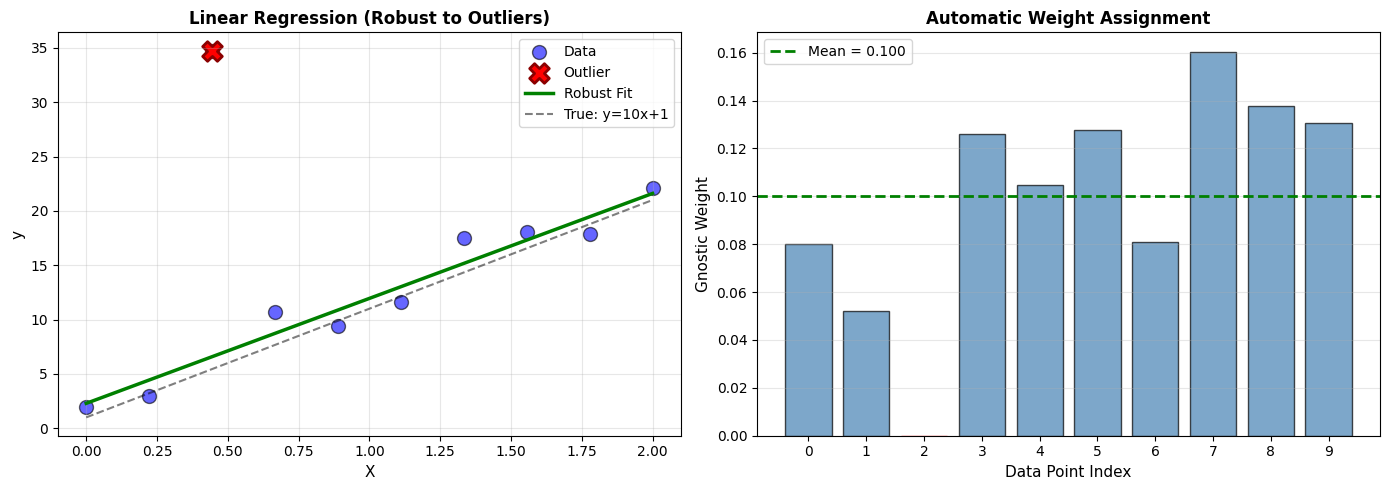


Key Insight: The outlier (point 2) gets LOW weight automatically
            This prevents it from distorting the fitted line!


In [14]:
# Create comprehensive visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Fitted line
X_test = np.linspace(0, 2, 100).reshape(-1, 1)
y_test = model.predict(X_test)
y_true = 10 * X_test + 1

ax1.scatter(X, y, color='blue', s=100, label='Data', alpha=0.6, edgecolors='black')
ax1.scatter(X[2], y[2], color='red', s=200, label='Outlier', marker='X', edgecolors='darkred', linewidths=2)
ax1.plot(X_test, y_test, 'g-', linewidth=2.5, label='Robust Fit')
ax1.plot(X_test, y_true, 'k--', linewidth=1.5, alpha=0.5, label='True: y=10x+1')
ax1.set_xlabel('X', fontsize=11)
ax1.set_ylabel('y', fontsize=11)
ax1.set_title('Linear Regression (Robust to Outliers)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Weights
bars = ax2.bar(range(len(weights)), weights, color='steelblue', edgecolor='black', alpha=0.7)
bars[2].set_color('red')
bars[2].set_alpha(0.8)
ax2.axhline(y=np.mean(weights), color='green', linestyle='--', 
            label=f'Mean = {np.mean(weights):.3f}', linewidth=2)
ax2.set_xlabel('Data Point Index', fontsize=11)
ax2.set_ylabel('Gnostic Weight', fontsize=11)
ax2.set_title('Automatic Weight Assignment', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(range(len(weights)))

plt.tight_layout()
plt.show()

print("\nKey Insight: The outlier (point 2) gets LOW weight automatically")
print("            This prevents it from distorting the fitted line!")

## Example 3: Cross-Validation

Evaluate model performance using k-fold cross-validation with custom metrics.

In [15]:
from machinegnostics.models import LinearRegressor, CrossValidator
from machinegnostics.metrics import mean_squared_error, mean_absolute_error

# Create model
cv_model = LinearRegressor(verbose=False)

# Perform 5-fold cross-validation with MAE
cv = CrossValidator(model=cv_model, X=X, y=y, k=5, random_seed=42)
cv_results = cv.evaluate(mean_absolute_error)

print("5-Fold Cross-Validation Results (Mean Absolute Error):")
print("-" * 50)
for fold, mae in enumerate(cv_results, 1):
    print(f"Fold {fold}: MAE = {mae:.4f}")

print(f"\nAverage MAE: {np.mean(cv_results):.4f}")
print(f"Std Dev:     {np.std(cv_results):.4f}")

5-Fold Cross-Validation Results (Mean Absolute Error):
--------------------------------------------------
Fold 1: MAE = 1.4345
Fold 2: MAE = 0.7265
Fold 3: MAE = 3.7457
Fold 4: MAE = 0.4003
Fold 5: MAE = 1.8272

Average MAE: 1.6268
Std Dev:     1.1732


In [16]:
# Compare multiple metrics
from machinegnostics.metrics import root_mean_squared_error

metrics = {
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    'RMSE': root_mean_squared_error
}

print("\nCross-Validation with Multiple Metrics:")
print("=" * 60)

for metric_name, metric_func in metrics.items():
    cv = CrossValidator(model=cv_model, X=X, y=y, k=5, random_seed=42)
    results = cv.evaluate(metric_func)
    
    print(f"\n{metric_name}:")
    print(f"  Mean:   {np.mean(results):.4f}")
    print(f"  Std:    {np.std(results):.4f}")
    print(f"  Min:    {np.min(results):.4f}")
    print(f"  Max:    {np.max(results):.4f}")


Cross-Validation with Multiple Metrics:

MAE:
  Mean:   1.6268
  Std:    1.1732
  Min:    0.4003
  Max:    3.7457

MSE:
  Mean:   7.7063
  Std:    12.3841
  Min:    0.2055
  Max:    32.3719

RMSE:
  Mean:   2.0287
  Std:    1.8949
  Min:    0.4533
  Max:    5.6896


In [17]:
# Access training history
history = model._history
history_valid = [h for h in history if h['h_loss'] is not None]

print("Training History Summary:")
print("-" * 50)
print(f"Total iterations: {len(history_valid)}")
print(f"Initial loss:     {history_valid[0]['h_loss']:.6f}")
print(f"Final loss:       {history_valid[-1]['h_loss']:.6f}")
print(f"Initial entropy:  {history_valid[0]['rentropy']:.6f}")
print(f"Final entropy:    {history_valid[-1]['rentropy']:.6f}")
print(f"\nConvergence: Loss decreased by {((history_valid[0]['h_loss'] - history_valid[-1]['h_loss']) / history_valid[0]['h_loss'] * 100):.2f}%")

Training History Summary:
--------------------------------------------------
Total iterations: 3
Initial loss:     6.595095
Final loss:       7.031062
Initial entropy:  0.129477
Final entropy:    0.118288

Convergence: Loss decreased by -6.61%


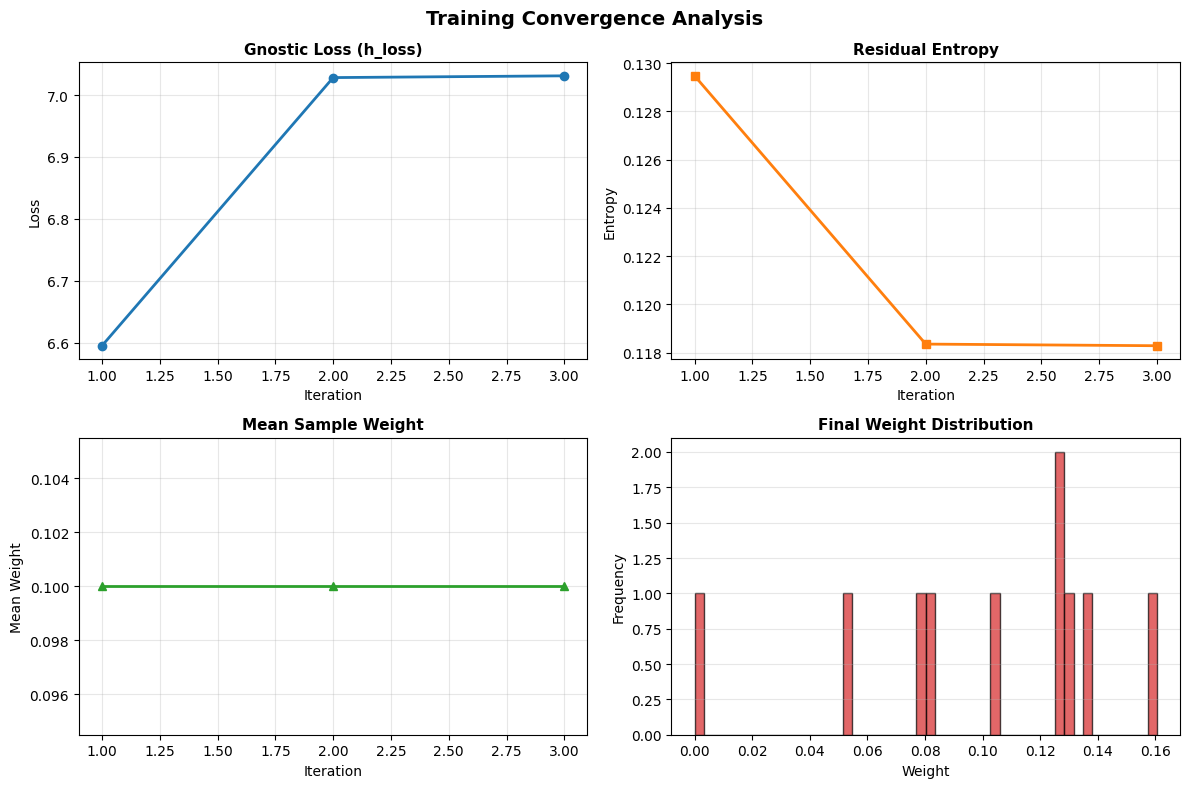


Key Observations:
- Loss and entropy decrease → model is learning
- Weights stabilize → robust sample weighting achieved
- Weight distribution shows automatic outlier down-weighting


In [18]:
# Extract metrics from history
iterations = [h['iteration'] for h in history_valid]
h_loss = [h['h_loss'] for h in history_valid]
rentropy = [h['rentropy'] for h in history_valid]
mean_weights = [np.mean(h['weights']) for h in history_valid]

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loss over iterations
axes[0, 0].plot(iterations, h_loss, marker='o', color='tab:blue', linewidth=2)
axes[0, 0].set_title('Gnostic Loss (h_loss)', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Entropy over iterations
axes[0, 1].plot(iterations, rentropy, marker='s', color='tab:orange', linewidth=2)
axes[0, 1].set_title('Residual Entropy', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Entropy')
axes[0, 1].grid(True, alpha=0.3)

# Mean weights over iterations
axes[1, 0].plot(iterations, mean_weights, marker='^', color='tab:green', linewidth=2)
axes[1, 0].set_title('Mean Sample Weight', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Mean Weight')
axes[1, 0].grid(True, alpha=0.3)

# Weight distribution (final iteration)
final_weights = history_valid[-1]['weights']
axes[1, 1].hist(final_weights, bins=50, color='tab:red', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Final Weight Distribution', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Weight')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Training Convergence Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Loss and entropy decrease → model is learning")
print("- Weights stabilize → robust sample weighting achieved")
print("- Weight distribution shows automatic outlier down-weighting")